# Building Footprint Extraction Setup

This notebook sets up the data processing pipeline for loading high-resolution drone orthophotos and building shapefiles, ensuring proper alignment via reprojection and rasterization.

In [2]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from rasterio.windows import Window
from shapely.geometry import box
import numpy as np

# Configure plots size
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
# Paths
# Using '28996_NADALA_ORTHO.tif' as the base orthophoto.
IMAGE_PATH = "../data/images/28996_NADALA_ORTHO.tif"
SHP_PATH = "../data/shp/Built_Up_Area_typ.shp"

print(f"Image Path: {IMAGE_PATH}")
print(f"Shapefile Path: {SHP_PATH}")

Image Path: ../data/images/28996_NADALA_ORTHO.tif
Shapefile Path: ../data/shp/Built_Up_Area_typ.shp


In [4]:
# 1. Load Orthophoto Metadata
with rasterio.open(IMAGE_PATH) as src:
    ortho_meta = src.meta.copy()
    ortho_crs = src.crs
    ortho_transform = src.transform
    ortho_shape = src.shape
    ortho_bounds = src.bounds
    
    print(f"Orthophoto CRS: {ortho_crs}")
    print(f"Orthophoto Shape: {ortho_shape}")
    print(f"Orthophoto Bounds: {ortho_bounds}")

Orthophoto CRS: EPSG:32643
Orthophoto Shape: (27390, 26259)
Orthophoto Bounds: BoundingBox(left=540378.3252300001, bottom=3489958.00821, right=541176.59883, top=3490790.66421)


In [5]:
# 2. Load and Reproject Shapefile
gdf = gpd.read_file(SHP_PATH)
print(f"Original Shapefile CRS: {gdf.crs}")

if gdf.crs != ortho_crs:
    print(f"Reprojecting shapefile from {gdf.crs} to {ortho_crs}...")
    gdf = gdf.to_crs(ortho_crs)
    print("Reprojection complete.")
else:
    print("CRS matches, no reprojection needed.")

# Check bounds intersection
shp_bounds = gdf.total_bounds
print(f"Shapefile bounds (reprojected): {shp_bounds}")

Original Shapefile CRS: EPSG:32643
CRS matches, no reprojection needed.
Shapefile bounds (reprojected): [ 508512.4309     3488140.2227      570932.38325358 3568121.8899    ]


In [6]:
# 3. Windowed Rasterization and Verification Function
def visualize_window(image_path, gdf, window_slice, title="Alignment Check"):
    """
    Reads a window from the large image, rasterizes the vector mask for that window, and plots them.
    window_slice: Window(col_off, row_off, width, height)
    """
    with rasterio.open(image_path) as src:
        # Read the image data in the window
        img_data = src.read(window=window_slice)
        
        # Calculate the transform for this specific window
        window_transform = src.window_transform(window_slice)
        
        # Get the spatial bounds of the window to filter polygons
        bounds = rasterio.windows.bounds(window_slice, src.transform)
        
        # Filter visible polygons using spatial index
        visible_polys = gdf.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
        if visible_polys.empty:
            print("No buildings found in this window.")
            mask = np.zeros((window_slice.height, window_slice.width), dtype='uint8')
        else:
            # Rasterize relevant polygons
            shapes = ((geom, 1) for geom in visible_polys.geometry)
            mask = rasterize(
                shapes,
                out_shape=(window_slice.height, window_slice.width),
                transform=window_transform,
                fill=0,
                default_value=1,
                dtype='uint8'
            )
            
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
    # Prepare RGB image for display
    if img_data.shape[0] >= 3:
        rgb_img = np.transpose(img_data[:3, :, :], (1, 2, 0))
    else:
        rgb_img = img_data[0, :, :]
        
    # Normalize if necessary (simple min-max for display)
    if rgb_img.dtype != np.uint8:
        rgb_img = ((rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min()) * 255).astype(np.uint8)

    ax[0].imshow(rgb_img)
    ax[0].set_title("Orthophoto Window")
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray', interpolation='nearest')
    ax[1].set_title("Rasterized Mask")
    ax[1].axis('off')
    
    # Overlay
    ax[2].imshow(rgb_img)
    ax[2].imshow(mask, alpha=0.5, cmap='spring')  # Overlay mask with transparency
    ax[2].set_title("Overlay")
    ax[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Displaying window: Window(col_off=0, row_off=0, width=2000, height=2000) around center (539722.4070767914, 3528131.0563000003)
No buildings found in this window.


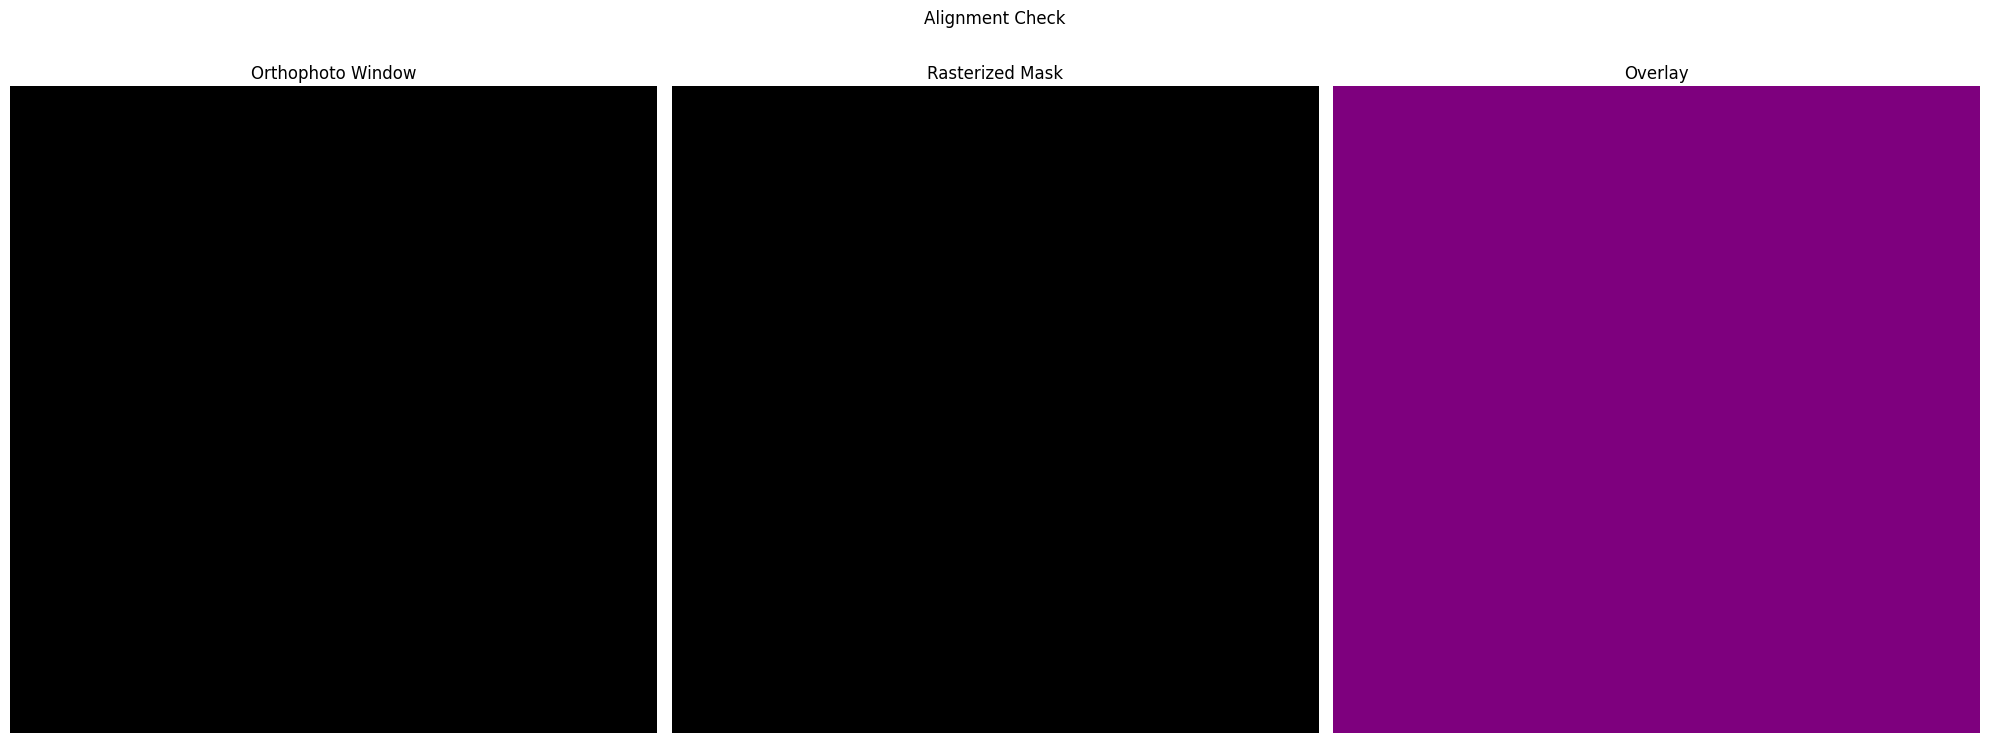

In [7]:
# 4. Select a Window and Visualize
# We'll attempt to find a center point from the shapefile bounds and sample there.

minx, miny, maxx, maxy = gdf.total_bounds
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2

with rasterio.open(IMAGE_PATH) as src:
    # Convert map coordinates to pixel coordinates
    row, col = src.index(center_x, center_y)
    
    # Define window size
    w_width, w_height = 2000, 2000
    
    # Calculate window offset
    col_off = max(0, col - w_width // 2)
    row_off = max(0, row - w_height // 2)
    
    # Create Window object
    window = Window(col_off, row_off, w_width, w_height)
    
    print(f"Displaying window: {window} around center ({center_x}, {center_y})")
    visualize_window(IMAGE_PATH, gdf, window)

In [8]:
# 5. Tiling Pipeline implementation
import os
import numpy as np
from tqdm import tqdm  # Changed from tqdm.notebook to standard tqdm to avoid IProgress error
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize

# Constants
TILE_SIZE = 1024
OUTPUT_DIR = "../data/tiles"
IMG_DIR = os.path.join(OUTPUT_DIR, "images")
MASK_DIR = os.path.join(OUTPUT_DIR, "masks")

# Create directories
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)
print(f"Output directories ready:\nImages: {IMG_DIR}\nMasks: {MASK_DIR}")

def process_tiles(image_path, gdf, tile_size=1024):
    """
    Iterates over the orthophoto in fixed-size windows.
    Checks for building overlap using the vector data.
    Saves RGB crops and corresponding rasterized binary masks.
    """
    with rasterio.open(image_path) as src:
        width = src.width
        height = src.height
        
        # Calculate total tiles for progress bar
        cols = range(0, width, tile_size)
        rows = range(0, height, tile_size)
        total_tiles = len(cols) * len(rows)
        
        print(f"Processing image ({width}x{height}) into {tile_size}x{tile_size} tiles...")
        print(f"Total grid cells to check: {total_tiles}")
        
        saved_count = 0
        
        # Base metadata for output tiles
        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": tile_size,
            "width": tile_size,
            "count": 3,  # Force RGB
            "dtype": "uint8"
        })
        
        mask_meta = meta.copy()
        mask_meta.update({"count": 1})  # Single band mask
        
        # Use tqdm for progress
        pbar = tqdm(total=total_tiles, desc="Generating Tiles")
        
        for col_off in cols:
            for row_off in rows:
                # Define window
                window = Window(col_off, row_off, tile_size, tile_size)
                
                # 1. Fast check: Use vector spatial index to see if any buildings intersect this window bounds
                # Get spatial bounds of the window
                win_bounds = rasterio.windows.bounds(window, src.transform)
                
                # Query spatial index
                possible_matches = gdf.cx[win_bounds[0]:win_bounds[2], win_bounds[1]:win_bounds[3]]
                
                if possible_matches.empty:
                    pbar.update(1)
                    continue
                
                # 2. Detailed processing: Read image and rasterize mask
                # boundless=True automatically pads tiles at edges with fill_value=0
                img_data = src.read(window=window, boundless=True, fill_value=0)
                
                # Ensure we strictly have 3 bands (RGB) - drop Alpha if present
                if img_data.shape[0] >= 3:
                    rgb_img = img_data[:3, :, :]
                else:
                    # Handle single band case if necessary (not expected for ortho)
                    pbar.update(1)
                    continue
                
                # Normalize/Cast to uint8
                if rgb_img.dtype != np.uint8:
                    # Assuming standard range or 16-bit, normalize to 0-255
                    # A safe heuristic if max > 255 is to scale, otherwise just cast
                    if rgb_img.max() > 255:
                         rgb_img = (rgb_img / 255).astype('uint8')
                    else:
                         rgb_img = rgb_img.astype('uint8')

                # Rasterize Mask
                # Get window transform
                win_transform = src.window_transform(window)
                
                shapes = ((geom, 1) for geom in possible_matches.geometry)
                
                mask = rasterize(
                    shapes,
                    out_shape=(tile_size, tile_size),
                    transform=win_transform,
                    fill=0,
                    default_value=1,
                    dtype='uint8'
                )
                
                # 3. Final Check: is the mask actually containing pixels? (removes empty overlaps)
                if mask.max() == 0:
                    pbar.update(1)
                    continue
                
                # 4. Save to Disk
                tile_id = f"tile_{col_off}_{row_off}.tif"
                
                # Update metadata with specific transform for this tile
                meta.update({"transform": win_transform})
                mask_meta.update({"transform": win_transform})
                
                # Write Image
                with rasterio.open(os.path.join(IMG_DIR, tile_id), 'w', **meta) as dst:
                    dst.write(rgb_img)
                    
                # Write Mask (must be 3D array (1, H, W) for rasterio check or consistent with count=1)
                with rasterio.open(os.path.join(MASK_DIR, tile_id), 'w', **mask_meta) as dst:
                    dst.write(mask, 1)
                
                saved_count += 1
                pbar.update(1)
        
        pbar.close()
        print(f"\nProcessing Complete.")
        print(f"Saved {saved_count} tiles to {OUTPUT_DIR}")

# Run the pipeline
process_tiles(IMAGE_PATH, gdf, TILE_SIZE)

Output directories ready:
Images: ../data/tiles/images
Masks: ../data/tiles/masks
Processing image (26259x27390) into 1024x1024 tiles...
Total grid cells to check: 702


Generating Tiles:  52%|█████▏    | 362/702 [01:18<01:51,  3.04it/s]/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': (((540794.1804244192, 3490438.244493237), (540794.1126661297, 3490438.2830306366), (540794.1804244192, 3490438.244493237)),)} at index 20 will not be rasterized.
  warnings.warn(
Generating Tiles: 100%|██████████| 702/702 [02:28<00:00,  4.72it/s]


Processing Complete.
Saved 429 tiles to ../data/tiles


In [9]:
# 6. Deep Learning Model Setup
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Check for CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# 6.1 Model Definition
# UNet with ResNet34 backbone, pretrained on ImageNet
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model.to(DEVICE)
print("Model initialized and moved to device.")

# 6.2 Loss Function
# Combination of BCE and Dice Loss for robust training with class imbalance
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEDiceLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)

    def forward(self, pred, target):
        # BCE
        bce = self.bce_loss(pred, target)
        # Dice
        dice = self.dice_loss(pred, target)
        
        return bce + dice

loss_fn = BCEDiceLoss()
print("Loss function: BCE + Dice Loss initialized.")

# 6.3 Metrics
# IoU (Jaccard Index) and Accuracy
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    """
    Calculates IoU and Accuracy for binary segmentation.
    pred_mask: logits from model (B, 1, H, W)
    true_mask: ground truth (B, 1, H, W)
    """
    # Apply sigmoid and threshold
    pred_mask = (torch.sigmoid(pred_mask) > threshold).float()
    
    # Flatten
    pred_flat = pred_mask.view(-1)
    true_flat = true_mask.view(-1)
    
    # IoU
    intersection = (pred_flat * true_flat).sum()
    union = pred_flat.sum() + true_flat.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Accuracy
    correct = (pred_flat == true_flat).sum()
    accuracy = correct.float() / true_flat.numel()
    
    return iou.item(), accuracy.item()

print("Metrics function defined (IoU, Accuracy).")

/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Model initialized and moved to device.
Loss function: BCE + Dice Loss initialized.
Metrics function defined (IoU, Accuracy).


In [10]:
# 7. Training Pipeline
import glob
import gc
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.cuda.amp import GradScaler, autocast

# Aggressive memory cleanup
gc.collect()
torch.cuda.empty_cache()

# 7.1 Dataset Definition
class BuildingDataset(Dataset):
    def __init__(self, items, transforms=None):
        self.items = items
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        mask_path = img_path.replace("/images/", "/masks/")

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        
        mask = (mask > 0).astype(float)
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)
            
        return image, mask
        
# 7.2 Augmentations - RESIZE TO 512x512 to fit in memory

train_transform = A.Compose([
    A.Resize(512, 512),  # <-- ADD THIS LINE
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(512, 512),  # <-- ADD THIS LINE
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

# 7.3 Data Loaders
all_tiles = glob.glob(f"{IMG_DIR}/*.tif")
np.random.shuffle(all_tiles)

split_ratio = 0.8
split_idx = int(len(all_tiles) * split_ratio)

train_files = all_tiles[:split_idx]
val_files = all_tiles[split_idx:]

print(f"Total tiles: {len(all_tiles)}")
print(f"Training: {len(train_files)}, Validation: {len(val_files)}")

train_ds = BuildingDataset(train_files, transforms=train_transform)
val_ds = BuildingDataset(val_files, transforms=val_transform)

# Use Batch Size 4 with AMP (should fit if BS=1 non-AMP failed closely)
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count() or 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 7.4 Training Loop
EPOCHS = 30
LEARNING_RATE = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
scaler = GradScaler() # Initialize Scaler for AMP

best_iou = 0.0
save_path = "../models/building_unet.pth"
os.makedirs("../models", exist_ok=True)

print("Starting training with AMP...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_iou = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, masks in loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Mixed Precision Forward
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)
        
        # Mixed Precision Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics (detach to ensure no memory leak)
        batch_iou, _ = calculate_metrics(outputs.detach(), masks)
        
        train_loss += loss.item()
        train_iou += batch_iou
        
        loop.set_postfix(loss=loss.item(), iou=batch_iou)
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    val_acc = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            with autocast():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
            
            iou, acc = calculate_metrics(outputs, masks)
            
            val_loss += loss.item()
            val_iou += iou
            val_acc += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    
    scheduler.step(avg_val_iou)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f} | Val Acc: {avg_val_acc:.4f}")
    
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model.state_dict(), save_path)
        print(f"Saved Best Model! (IoU: {best_iou:.4f})")
        
print(f"\nTraining Complete. Best IoU: {best_iou:.4f}")

/tmp/ipykernel_28881/2607385786.py:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize Scaler for AMP


Total tiles: 429
Training: 343, Validation: 86
Starting training with AMP...


Epoch 1/30:   0%|          | 0/86 [00:00<?, ?it/s]/tmp/ipykernel_28881/2607385786.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 86/86 [00:13<00:00,  6.24it/s, iou=0.614, loss=0.689]
/tmp/ipykernel_28881/2607385786.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 Summary:
Train Loss: 0.8215 | Train IoU: 0.6134
Val Loss: 0.5607 | Val IoU: 0.7544 | Val Acc: 0.8553
Saved Best Model! (IoU: 0.7544)


Epoch 2/30: 100%|██████████| 86/86 [00:12<00:00,  6.97it/s, iou=0.802, loss=0.456]



Epoch 2 Summary:
Train Loss: 0.5925 | Train IoU: 0.7206
Val Loss: 0.5021 | Val IoU: 0.7766 | Val Acc: 0.8733
Saved Best Model! (IoU: 0.7766)


Epoch 3/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.868, loss=0.329]



Epoch 3 Summary:
Train Loss: 0.5617 | Train IoU: 0.7285
Val Loss: 0.4516 | Val IoU: 0.8031 | Val Acc: 0.8962
Saved Best Model! (IoU: 0.8031)


Epoch 4/30: 100%|██████████| 86/86 [00:12<00:00,  7.01it/s, iou=0.843, loss=0.347]



Epoch 4 Summary:
Train Loss: 0.4578 | Train IoU: 0.7852
Val Loss: 0.4236 | Val IoU: 0.8107 | Val Acc: 0.8947
Saved Best Model! (IoU: 0.8107)


Epoch 5/30: 100%|██████████| 86/86 [00:12<00:00,  6.94it/s, iou=0.819, loss=0.358]



Epoch 5 Summary:
Train Loss: 0.3967 | Train IoU: 0.8136
Val Loss: 0.3738 | Val IoU: 0.8282 | Val Acc: 0.9087
Saved Best Model! (IoU: 0.8282)


Epoch 6/30: 100%|██████████| 86/86 [00:12<00:00,  6.89it/s, iou=0.687, loss=0.545]



Epoch 6 Summary:
Train Loss: 0.3510 | Train IoU: 0.8336
Val Loss: 0.3496 | Val IoU: 0.8399 | Val Acc: 0.9185
Saved Best Model! (IoU: 0.8399)


Epoch 7/30: 100%|██████████| 86/86 [00:12<00:00,  6.98it/s, iou=0.793, loss=0.387]



Epoch 7 Summary:
Train Loss: 0.3507 | Train IoU: 0.8322
Val Loss: 0.4088 | Val IoU: 0.8134 | Val Acc: 0.8983


Epoch 8/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.787, loss=0.36] 



Epoch 8 Summary:
Train Loss: 0.3203 | Train IoU: 0.8505
Val Loss: 0.3361 | Val IoU: 0.8449 | Val Acc: 0.9187
Saved Best Model! (IoU: 0.8449)


Epoch 9/30: 100%|██████████| 86/86 [00:12<00:00,  6.91it/s, iou=0.906, loss=0.241]



Epoch 9 Summary:
Train Loss: 0.3265 | Train IoU: 0.8436
Val Loss: 0.3089 | Val IoU: 0.8532 | Val Acc: 0.9254
Saved Best Model! (IoU: 0.8532)


Epoch 10/30: 100%|██████████| 86/86 [00:12<00:00,  7.00it/s, iou=0.906, loss=0.231]



Epoch 10 Summary:
Train Loss: 0.2857 | Train IoU: 0.8640
Val Loss: 0.3344 | Val IoU: 0.8402 | Val Acc: 0.9188


Epoch 11/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.823, loss=0.407]



Epoch 11 Summary:
Train Loss: 0.2465 | Train IoU: 0.8804
Val Loss: 0.3112 | Val IoU: 0.8534 | Val Acc: 0.9243
Saved Best Model! (IoU: 0.8534)


Epoch 12/30: 100%|██████████| 86/86 [00:12<00:00,  6.89it/s, iou=0.73, loss=0.413] 



Epoch 12 Summary:
Train Loss: 0.2469 | Train IoU: 0.8744
Val Loss: 0.2878 | Val IoU: 0.8592 | Val Acc: 0.9285
Saved Best Model! (IoU: 0.8592)


Epoch 13/30: 100%|██████████| 86/86 [00:12<00:00,  6.96it/s, iou=0.914, loss=0.271]



Epoch 13 Summary:
Train Loss: 0.2335 | Train IoU: 0.8865
Val Loss: 0.2952 | Val IoU: 0.8572 | Val Acc: 0.9283


Epoch 14/30: 100%|██████████| 86/86 [00:12<00:00,  6.96it/s, iou=0.482, loss=0.687]



Epoch 14 Summary:
Train Loss: 0.1907 | Train IoU: 0.9044
Val Loss: 0.2910 | Val IoU: 0.8584 | Val Acc: 0.9304


Epoch 15/30: 100%|██████████| 86/86 [00:12<00:00,  6.91it/s, iou=0.933, loss=0.15] 



Epoch 15 Summary:
Train Loss: 0.3031 | Train IoU: 0.8437
Val Loss: 0.3253 | Val IoU: 0.8462 | Val Acc: 0.9228


Epoch 16/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.896, loss=0.229] 



Epoch 16 Summary:
Train Loss: 0.2193 | Train IoU: 0.8891
Val Loss: 0.3383 | Val IoU: 0.8294 | Val Acc: 0.9188


Epoch 17/30: 100%|██████████| 86/86 [00:12<00:00,  6.95it/s, iou=0.942, loss=0.134] 



Epoch 17 Summary:
Train Loss: 0.1799 | Train IoU: 0.9098
Val Loss: 0.2804 | Val IoU: 0.8661 | Val Acc: 0.9302
Saved Best Model! (IoU: 0.8661)


Epoch 18/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.926, loss=0.131] 



Epoch 18 Summary:
Train Loss: 0.1712 | Train IoU: 0.9173
Val Loss: 0.2749 | Val IoU: 0.8684 | Val Acc: 0.9321
Saved Best Model! (IoU: 0.8684)


Epoch 19/30: 100%|██████████| 86/86 [00:12<00:00,  6.94it/s, iou=0.948, loss=0.0981]



Epoch 19 Summary:
Train Loss: 0.1633 | Train IoU: 0.9192
Val Loss: 0.2615 | Val IoU: 0.8732 | Val Acc: 0.9357
Saved Best Model! (IoU: 0.8732)


Epoch 20/30: 100%|██████████| 86/86 [00:12<00:00,  6.98it/s, iou=0.896, loss=0.183] 



Epoch 20 Summary:
Train Loss: 0.1732 | Train IoU: 0.9164
Val Loss: 0.2601 | Val IoU: 0.8725 | Val Acc: 0.9350


Epoch 21/30: 100%|██████████| 86/86 [00:12<00:00,  6.91it/s, iou=0.935, loss=0.159] 



Epoch 21 Summary:
Train Loss: 0.1713 | Train IoU: 0.9173
Val Loss: 0.2637 | Val IoU: 0.8737 | Val Acc: 0.9345
Saved Best Model! (IoU: 0.8737)


Epoch 22/30: 100%|██████████| 86/86 [00:12<00:00,  6.96it/s, iou=0.954, loss=0.105] 



Epoch 22 Summary:
Train Loss: 0.1475 | Train IoU: 0.9280
Val Loss: 0.2696 | Val IoU: 0.8735 | Val Acc: 0.9347


Epoch 23/30: 100%|██████████| 86/86 [00:12<00:00,  6.92it/s, iou=0.941, loss=0.121] 



Epoch 23 Summary:
Train Loss: 0.1572 | Train IoU: 0.9210
Val Loss: 0.2534 | Val IoU: 0.8776 | Val Acc: 0.9374
Saved Best Model! (IoU: 0.8776)


Epoch 24/30: 100%|██████████| 86/86 [00:12<00:00,  6.96it/s, iou=0.917, loss=0.16]  



Epoch 24 Summary:
Train Loss: 0.1407 | Train IoU: 0.9321
Val Loss: 0.2692 | Val IoU: 0.8758 | Val Acc: 0.9357


Epoch 25/30: 100%|██████████| 86/86 [00:12<00:00,  6.92it/s, iou=0.967, loss=0.0807]



Epoch 25 Summary:
Train Loss: 0.1530 | Train IoU: 0.9235
Val Loss: 0.2642 | Val IoU: 0.8739 | Val Acc: 0.9350


Epoch 26/30: 100%|██████████| 86/86 [00:12<00:00,  6.93it/s, iou=0.93, loss=0.124]  



Epoch 26 Summary:
Train Loss: 0.1524 | Train IoU: 0.9295
Val Loss: 0.2767 | Val IoU: 0.8736 | Val Acc: 0.9343


Epoch 27/30: 100%|██████████| 86/86 [00:12<00:00,  6.95it/s, iou=0.945, loss=0.104] 



Epoch 27 Summary:
Train Loss: 0.1393 | Train IoU: 0.9301
Val Loss: 0.2624 | Val IoU: 0.8754 | Val Acc: 0.9368


Epoch 28/30: 100%|██████████| 86/86 [00:12<00:00,  6.95it/s, iou=0.906, loss=0.227] 



Epoch 28 Summary:
Train Loss: 0.1306 | Train IoU: 0.9369
Val Loss: 0.2669 | Val IoU: 0.8750 | Val Acc: 0.9357


Epoch 29/30: 100%|██████████| 86/86 [00:12<00:00,  6.92it/s, iou=0.87, loss=0.262]  



Epoch 29 Summary:
Train Loss: 0.1517 | Train IoU: 0.9299
Val Loss: 0.2796 | Val IoU: 0.8714 | Val Acc: 0.9330


Epoch 30/30: 100%|██████████| 86/86 [00:12<00:00,  6.96it/s, iou=0.938, loss=0.155] 



Epoch 30 Summary:
Train Loss: 0.1351 | Train IoU: 0.9339
Val Loss: 0.2712 | Val IoU: 0.8746 | Val Acc: 0.9352

Training Complete. Best IoU: 0.8776


In [10]:
import os
import rasterio
import numpy as np
import torch
import cv2
import gc
from rasterio.windows import Window
from tqdm import tqdm
from PIL import Image

# 1. Configuration
INFERENCE_IMAGE_PATH = "../data/images/TIMMOWAL_37695_ORI.tif"
if not os.path.exists(INFERENCE_IMAGE_PATH):
    import glob
    available = glob.glob("../data/images/*.tif")
    if available:
        INFERENCE_IMAGE_PATH = available[0]

OUTPUT_DIR = "../outputs"
MODEL_PATH = "../models/building_unet.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TILE_SIZE = 1024
INPUT_SIZE = 512

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Inference input: {INFERENCE_IMAGE_PATH}")
print(f"Output directory: {OUTPUT_DIR}")

# 2. Load Model
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None, 
    in_channels=3,
    classes=1,
)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
else:
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}.")

# 3. Inference Function
def predict_large_image(image_path, model, tile_size, input_size, device):
    with rasterio.open(image_path) as src:
        h, w = src.height, src.width
        profile = src.profile.copy()
        full_mask = np.zeros((h, w), dtype=np.uint8)
        print(f"Image Dimensions: {w}x{h}")
        
        x_steps = list(range(0, w, tile_size))
        y_steps = list(range(0, h, tile_size))
        total_tiles = len(x_steps) * len(y_steps)
        
        with tqdm(total=total_tiles, desc="Processing Tiles") as pbar:
            for row in y_steps:
                for col in x_steps:
                    window = Window(col, row, min(tile_size, w - col), min(tile_size, h - row))
                    img_data = src.read((1, 2, 3), window=window)
                    curr_h, curr_w = img_data.shape[1], img_data.shape[2]
                    
                    img_np = img_data.transpose(1, 2, 0)
                    img_resized = cv2.resize(img_np, (input_size, input_size))
                    
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img_norm = (img_resized / 255.0 - mean) / std
                    
                    img_t = torch.from_numpy(img_norm.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        with torch.amp.autocast('cuda'):
                            output = model(img_t)
                            output_mask = torch.sigmoid(output).cpu().numpy()[0, 0].astype(np.float32)
                    
                    mask_resized = cv2.resize(output_mask, (curr_w, curr_h))
                    binary_mask = (mask_resized > 0.5).astype(np.uint8)
                    full_mask[row:row+curr_h, col:col+curr_w] = binary_mask
                    pbar.update(1)
    return full_mask, profile

# 4. Run Prediction
print("Starting main inference...")
predicted_mask, source_profile = predict_large_image(INFERENCE_IMAGE_PATH, model, TILE_SIZE, INPUT_SIZE, DEVICE)

# 5.1 Save as GeoTIFF
tif_output_path = os.path.join(OUTPUT_DIR, "building_mask.tif")
source_profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open(tif_output_path, 'w', **source_profile) as dst:
    dst.write(predicted_mask, 1)
print(f"Saved CRS-preserved mask to: {tif_output_path}")

# 5.2 Save as PNG
png_output_path = os.path.join(OUTPUT_DIR, "building_mask.png")
Image.fromarray(predicted_mask * 255).save(png_output_path)
print(f"Saved binary mask PNG to: {png_output_path}")

# 5.3 Create Downsampled Overlay (Memory-Efficient)
overlay_path = os.path.join(OUTPUT_DIR, "building_overlay.png")
print("Generating downsampled overlay...")

MAX_DIM = 4096
with rasterio.open(INFERENCE_IMAGE_PATH) as src:
    h, w = src.height, src.width
    scale = min(MAX_DIM / w, MAX_DIM / h, 1.0)
    new_w, new_h = int(w * scale), int(h * scale)
    print(f"Downsampling to {new_w}x{new_h}")
    image_rgb = src.read((1, 2, 3), out_shape=(3, new_h, new_w),
                         resampling=rasterio.enums.Resampling.bilinear).transpose(1, 2, 0)

mask_small = cv2.resize(predicted_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
overlay_img = image_rgb.copy()
red_color = np.zeros_like(overlay_img)
red_color[:, :, 0] = 255
alpha = 0.5
mask_indices = mask_small == 1
overlay_img[mask_indices] = (alpha * overlay_img[mask_indices] + (1 - alpha) * red_color[mask_indices]).astype(np.uint8)
Image.fromarray(overlay_img).save(overlay_path)
print(f"Saved Overlay PNG to: {overlay_path}")

del image_rgb, overlay_img, mask_small, red_color, predicted_mask
gc.collect()
print("Done!")

Inference input: ../data/images/TIMMOWAL_37695_ORI.tif
Output directory: ../outputs
Model loaded successfully.
Starting main inference...
Image Dimensions: 31100x30532


Processing Tiles: 100%|██████████| 930/930 [00:31<00:00, 29.45it/s]


Saved CRS-preserved mask to: ../outputs/building_mask.tif
Saved binary mask PNG to: ../outputs/building_mask.png
Generating downsampled overlay...
Downsampling to 4095x4021
Saved Overlay PNG to: ../outputs/building_overlay.png
Done!


In [11]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
import os

# Configuration
MASK_INPUT_PATH = "../outputs/utility_mask.png"
MASK_OUTPUT_PATH = "../outputs/utility_mask_cleaned.png"
OVERLAY_OUTPUT_PATH = "../outputs/utility_overlay_final.png"
MIN_COMPONENT_SIZE = 50  # pixels

# 1. Load Predicted Mask
print("Loading predicted mask...")
mask = np.array(Image.open(MASK_INPUT_PATH).convert('L'))
mask_binary = (mask > 127).astype(np.uint8)  # Ensure binary

print(f"Original mask shape: {mask_binary.shape}")
print(f"Original utility pixels: {mask_binary.sum()}")

# 2. Morphological Opening (Remove Noise)
print("\n1. Applying morphological opening...")
# Kernel for opening (removes small bright spots/noise)
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask_opened = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel_open, iterations=1)

print(f"   After opening: {mask_opened.sum()} pixels")

# 3. Remove Small Components
print(f"\n2. Removing components smaller than {MIN_COMPONENT_SIZE} pixels...")
# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    mask_opened, connectivity=8
)

# Filter by size
mask_filtered = np.zeros_like(mask_opened)
for i in range(1, num_labels):  # Skip background (label 0)
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= MIN_COMPONENT_SIZE:
        mask_filtered[labels == i] = 1

print(f"   Components before: {num_labels - 1}")
print(f"   Components after: {(mask_filtered > 0).sum() > 0}")
print(f"   Pixels remaining: {mask_filtered.sum()}")

# 4. Morphological Closing (Smooth Boundaries & Fill Gaps)
print("\n3. Smoothing boundaries...")
# Closing smooths object contours and closes small holes
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_cleaned = cv2.morphologyEx(mask_filtered, cv2.MORPH_CLOSE, kernel_close, iterations=1)

print(f"   Final utility pixels: {mask_cleaned.sum()}")

# 5. Save Cleaned Mask
print(f"\n✓ Saving cleaned mask to: {MASK_OUTPUT_PATH}")
Image.fromarray(mask_cleaned * 255).save(MASK_OUTPUT_PATH)

# 6. Create Final Overlay (Downsampled for presentation)
print("\nCreating presentation-quality overlay...")

# Load original image (downsampled)
INFERENCE_IMAGE_PATH = "../data/images/TIMMOWAL_37695_ORI.tif"
MAX_DIM = 4096

import rasterio
with rasterio.open(INFERENCE_IMAGE_PATH) as src:
    h, w = src.height, src.width
    scale = min(MAX_DIM / w, MAX_DIM / h, 1.0)
    new_w, new_h = int(w * scale), int(h * scale)
    
    print(f"   Overlay size: {new_w}x{new_h}")
    
    image_rgb = src.read(
        (1, 2, 3),
        out_shape=(3, new_h, new_w),
        resampling=rasterio.enums.Resampling.bilinear
    ).transpose(1, 2, 0)

# Resize cleaned mask to match
mask_display = cv2.resize(mask_cleaned, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

# Create professional overlay with semi-transparent utilities in cyan/blue
overlay_img = image_rgb.copy()
# Use cyan for better visibility on aerial imagery
overlay_color = np.array([0, 255, 255])  # Cyan in RGB

# Create colored mask
color_mask = np.zeros_like(image_rgb)
color_mask[mask_display == 1] = overlay_color

# Blend with alpha
alpha = 0.6
final_overlay = (alpha * image_rgb + (1 - alpha) * color_mask).astype(np.uint8)
# Only apply where mask is present
final_overlay[mask_display == 0] = image_rgb[mask_display == 0]

# Save
Image.fromarray(final_overlay).save(OVERLAY_OUTPUT_PATH)
print(f"✓ Saved final overlay to: {OVERLAY_OUTPUT_PATH}")

# 7. Presentation Visualization
print("\nGenerating comparison visualization...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.2)

# Row 1: Processing stages
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(mask_binary, cmap='gray')
ax1.set_title('1. Original Prediction', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(mask_opened, cmap='gray')
ax2.set_title('2. After Opening (Noise Removal)', fontsize=14, fontweight='bold')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(mask_filtered, cmap='gray')
ax3.set_title(f'3. After Size Filter (>{MIN_COMPONENT_SIZE}px)', fontsize=14, fontweight='bold')
ax3.axis('off')

# Row 2: Final results
ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(mask_cleaned, cmap='gray')
ax4.set_title('4. Final Cleaned Mask', fontsize=14, fontweight='bold')
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 1:])
ax5.imshow(final_overlay)
ax5.set_title('Final Overlay - Utilities in Cyan', fontsize=14, fontweight='bold')
ax5.axis('off')

# Add statistics box
stats_text = f"""
Post-Processing Statistics:
━━━━━━━━━━━━━━━━━━━━━━
Original pixels:    {mask_binary.sum():,}
After opening:      {mask_opened.sum():,}
After filtering:    {mask_filtered.sum():,}
Final cleaned:      {mask_cleaned.sum():,}

Noise removed:      {mask_binary.sum() - mask_cleaned.sum():,} pixels
Reduction:          {((mask_binary.sum() - mask_cleaned.sum()) / max(mask_binary.sum(), 1) * 100):.1f}%
"""

fig.text(0.02, 0.02, stats_text, fontsize=11, family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Utility Segmentation - Post-Processing Pipeline', 
             fontsize=16, fontweight='bold', y=0.98)

# Save figure
comparison_path = "../outputs/utility_postprocessing_comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved comparison to: {comparison_path}")

plt.show()

print("\n" + "="*60)
print("Post-processing Complete!")
print("="*60)
print(f"\nOutput files:")
print(f"  • Cleaned mask:  {MASK_OUTPUT_PATH}")
print(f"  • Final overlay: {OVERLAY_OUTPUT_PATH}")
print(f"  • Comparison:    {comparison_path}")

Loading predicted mask...


DecompressionBombError: Image size (949545200 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.